# Data cleaning + EDA 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/ashademeij/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/ashademeij/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Storing all necessary df's 

The data was retrieved from the MIMIC-IV dataset, available on PhysioNet: https://physionet.org/content/mimiciv/2.2/  

In [3]:
admissions = pd.read_csv('/Users/ashademeij/Downloads/Thesis/mimic-iv-2.2/hosp/admissions.csv')
patients = pd.read_csv('/Users/ashademeij/Downloads/Thesis/mimic-iv-2.2/hosp/patients.csv')
icuStays = pd.read_csv('/Users/ashademeij/Downloads/Thesis/mimic-iv-2.2/icu/icustays.csv') # This is what we are interested in --> the stays in ICU
diagnoses = pd.read_csv("/Users/ashademeij/Downloads/Thesis/mimic-iv-2.2/hosp/diagnoses_icd.csv.gz")
# procedures = pd.read_csv("/Users/ashademeij/Downloads/Thesis/mimic-iv-2.2/hosp/prescriptions.csv", low_memory=True) --> will be read later due to the size


In [4]:
# only interested in stays of at least one day
icuStays = icuStays[icuStays['los'] >= 1]

# common hadm_id values between icustays_df and admissions_df
common_hadm_ids = set(icuStays['hadm_id']) & set(admissions['hadm_id'])

# only keep instances that have common hadm_id in all df's
admissions = admissions[admissions['hadm_id'].isin(common_hadm_ids)]
icuStays = icuStays[icuStays['hadm_id'].isin(common_hadm_ids)]


diagnoses = diagnoses[(diagnoses['subject_id'].isin(icuStays['subject_id'])) & 
                                  (diagnoses['hadm_id'].isin(icuStays['hadm_id']))]

subjects = set(admissions['subject_id'])
stays = set(icuStays['stay_id'])

In [4]:
print(icuStays.shape)

(57734, 8)


### ICU stays

In [5]:
icuStays.drop(['last_careunit', 'first_careunit'], axis=1, inplace=True)

#### 1. Admissions

In [6]:
admissions.columns

# this df has important columns that could influence the models: 'insurance', 'race', 'marital_status'

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag'],
      dtype='object')

In [7]:
# creating groups of admission type
admissions = admissions[admissions['admission_location'] != 'INFORMATION NOT AVAILABLE']

def group_admission_location(icu_name):
    if icu_name == 'EMERGENCY ROOM':
        return 'Emergency'
    elif icu_name in ['PHYSICIAN REFERRAL', 'CLINIC REFERRAL', 'AMBULATORY SURGERY TRANSFER']:
        return 'Referral'
    elif icu_name in ['TRANSFER FROM HOSPITAL', 'TRANSFER FROM SKILLED NURSING FACILITY', 'INTERNAL TRANSFER TO OR FROM PSYCH']:
        return 'Transfer'
    else:
        return 'Other'

admissions['admission_location'] = admissions['admission_location'].apply(group_admission_location)


In [8]:
print(len(admissions['race'].unique()))

print((admissions['race'] == 'UNABLE TO OBTAIN').sum()) # exclude these entries from our analysis
print((admissions['race'] == 'UNKNOWN').sum()) # exclude these entries from our analysis
# 'PATIENT DECLINED TO ANSWER' is this a case i should include/exclude

print(admissions['race'].unique())

# 33 different races --> will be clustered

33
633
4752
['WHITE' 'BLACK/AFRICAN AMERICAN' 'OTHER' 'UNKNOWN' 'UNABLE TO OBTAIN'
 'WHITE - RUSSIAN' 'BLACK/CAPE VERDEAN' 'PORTUGUESE'
 'HISPANIC/LATINO - PUERTO RICAN' 'ASIAN - SOUTH EAST ASIAN'
 'WHITE - BRAZILIAN' 'HISPANIC OR LATINO' 'WHITE - OTHER EUROPEAN'
 'BLACK/AFRICAN' 'HISPANIC/LATINO - SALVADORAN' 'ASIAN'
 'PATIENT DECLINED TO ANSWER' 'BLACK/CARIBBEAN ISLAND'
 'HISPANIC/LATINO - DOMINICAN' 'ASIAN - KOREAN' 'ASIAN - CHINESE'
 'ASIAN - ASIAN INDIAN' 'WHITE - EASTERN EUROPEAN'
 'HISPANIC/LATINO - HONDURAN' 'HISPANIC/LATINO - COLUMBIAN'
 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'
 'HISPANIC/LATINO - GUATEMALAN' 'AMERICAN INDIAN/ALASKA NATIVE'
 'HISPANIC/LATINO - CENTRAL AMERICAN' 'HISPANIC/LATINO - MEXICAN'
 'SOUTH AMERICAN' 'MULTIPLE RACE/ETHNICITY' 'HISPANIC/LATINO - CUBAN']


In [9]:
# Drop admissions with 'UNABLE TO OBTAIN' or 'UNKNOWN' race
admissions = admissions[~admissions['race'].isin(['UNABLE TO OBTAIN', 'UNKNOWN'])]

# method to group races
def group_race(race):
    if 'WHITE' in race:
        return 'White'
    elif 'BLACK' in race:
        return 'Black/African American'
    elif 'HISPANIC' in race or 'LATINO' in race:
        return 'Hispanic/Latino'
    elif 'ASIAN' in race:
        return 'Asian'
    else:
        return 'Other'

admissions['raceGrouped'] = admissions['race'].apply(group_race)
print(admissions['raceGrouped'].value_counts())

raceGrouped
White                     35915
Black/African American     5534
Other                      2537
Hispanic/Latino            1961
Asian                      1554
Name: count, dtype: int64


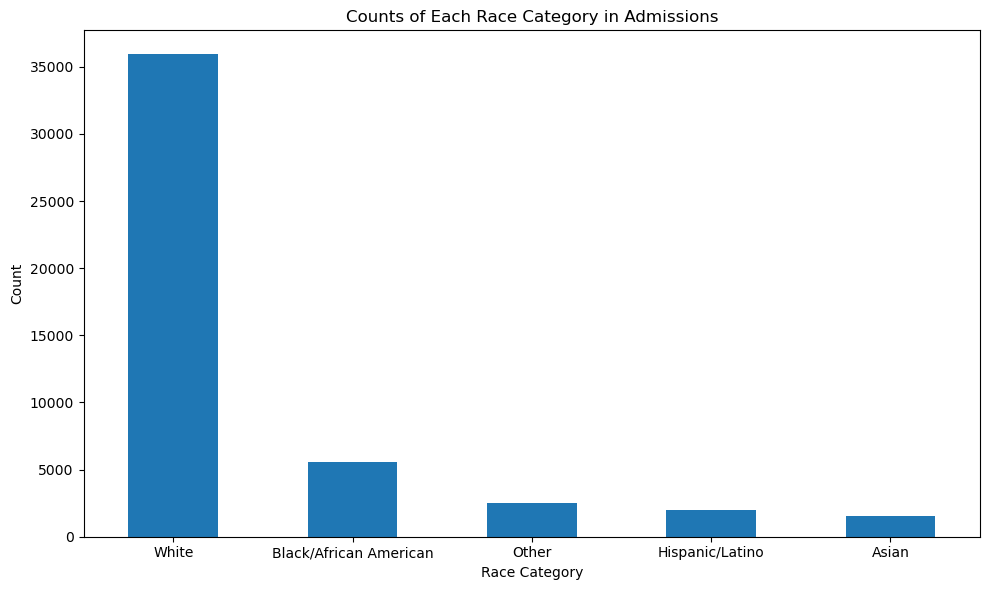

In [10]:
race_counts = admissions['raceGrouped'].value_counts()

plt.figure(figsize=(10, 6))
race_counts.plot(kind='bar')
plt.title('Counts of Each Race Category in Admissions')
plt.xlabel('Race Category')
plt.ylabel('Count')
plt.xticks(rotation=360)  
plt.tight_layout()
plt.show()

In [14]:
len(admissions['insurance'].unique())

3

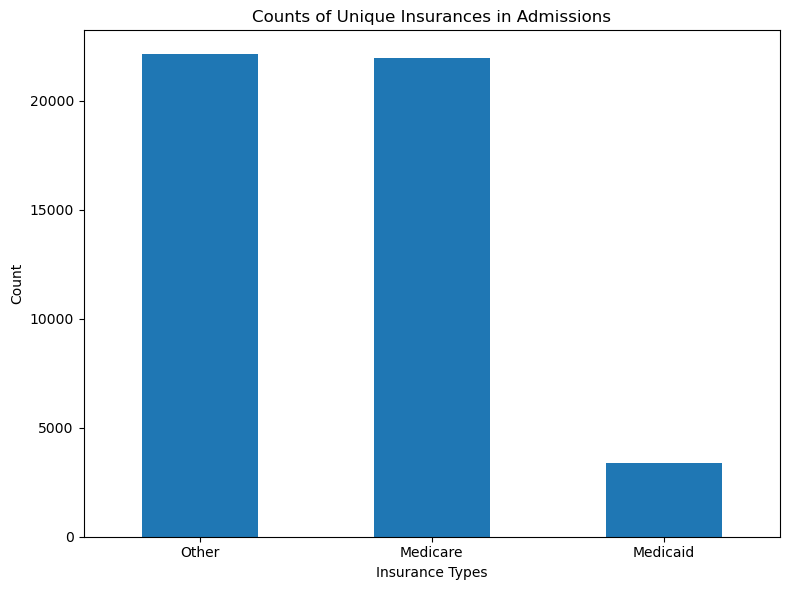

In [16]:
insurance_counts = admissions['insurance'].value_counts()

plt.figure(figsize=(8, 6))
insurance_counts.plot(kind='bar')
plt.title('Counts of Unique Insurances in Admissions')
plt.xlabel('Insurance Types')
plt.ylabel('Count')
plt.xticks(rotation=360)  
plt.tight_layout()
plt.show()

In [12]:
icuStays.shape

(57734, 6)

In [17]:
# add 'admission_location' 'insurance' 'raceGroup_2' 'marital_status' to icuStays based on subjectID
icuStays = pd.merge(icuStays, admissions[['subject_id', 'hadm_id', 'admission_location', 'insurance', 'raceGrouped', 'marital_status']],
                    on=['subject_id', 'hadm_id'], how='inner')

#### 2. Patients

In [18]:
patients = patients[patients['subject_id'].isin(subjects)]
# this df has important columns that could influence the models: 'gender' & 'anchor_age'

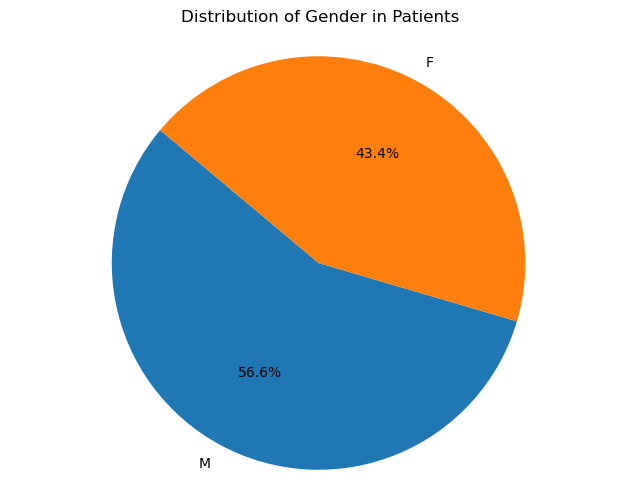

In [19]:
gender = patients['gender'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(gender, labels=gender.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Gender in Patients')
plt.axis('equal')  
plt.show()

In [20]:
# Make gender binary for modelling: Male=1, Female = 0
patients['gender'] = np.array(patients['gender'] == 'M').astype(int)

From the pie chart one can see that there is no drastic imbalance

In [21]:
print("min age: ", patients['anchor_age'].min())
print("max age: ", patients['anchor_age'].max())
print("mean age: ", patients['anchor_age'].mean())

min age:  18
max age:  91
mean age:  63.97113382547795


In [22]:
age_bins = [18, 25, 45, 65, 89, float('inf')]
age_labels = ['18-24', '25-44', '45-64', '65-88', '89+']
patients['age_group'] = pd.cut(patients['anchor_age'], bins=age_bins, labels=age_labels, right=False)

age_group_dummies = pd.get_dummies(patients['age_group'], prefix='age')
patients = pd.concat([patients, age_group_dummies], axis=1)

patients.drop(['anchor_age', 'age_group', 'anchor_year', 'anchor_year_group', 'dod'], axis=1, inplace=True)

In [23]:
# add gender and age groups to icustays too based on subjectID

icuStays = pd.merge(icuStays, patients[['subject_id', 'gender','age_18-24','age_25-44','age_45-64','age_65-88','age_89+']],
                    on='subject_id', how='inner')

In [55]:
icuStays.shape

(51703, 17)

#### 3. ICUstays

In [24]:
icuStays = icuStays.sort_values(by=['subject_id', 'intime'])

# feature engineering

# calculating the number of previous stays and the average LOS of those stays
icuStays['previous_stays'] = icuStays.groupby('subject_id').cumcount()
icuStays['prev_los_avg'] = icuStays.groupby('subject_id')['los'].shift().expanding().mean()

# Fill missing values in 'prev_los_avg' column with 0 (the first stay of each subject_id/patient)
icuStays['prev_los_avg'].fillna(0, inplace=True)

#### 4. Diagnoses

In [24]:
diagnoses = diagnoses[diagnoses['hadm_id'].isin(common_hadm_ids)]
diagnoses_original = diagnoses.copy() # we'll use this later

print(diagnoses.shape)

(948064, 5)


In [33]:
print(diagnoses['icd_version'].unique())

print((diagnoses['icd_version'] == 9).sum()/len(diagnoses))
print((diagnoses['icd_version'] == 10).sum()/len(diagnoses))


# we have 2 different icd_versions so we will transform version icd_9 to icd_10

[ 9 10]
0.5472025095352212
0.45279749046477874


There are 2 different version of ICD codes in the datset, namely 9 (58% of data) and 10 (42% of data). The following website, https://www.cdc.gov/nchs/icd/icd10cm_pcs_background.htm#:~:text=Code%20set%20differences,categories%20instead%20of%20numeric%20ones, states that ICD-9 codes are very different than ICD-10 code set. Therfore, the icd 9 code will be transformed into icd10.  It also says the followig: there are nearly 5 times as many diagnosis codes in ICD-10-CM than in ICD-9-CM. ICD-10 has alphanumeric categories instead of numeric ones.

The model needs to ensure consistency in how it interprets and processes the diagnosis codes.the model must handle them appropriately to avoid misinterpretation or errors in predictions.

In [34]:
# mapping retrieved from: https://www.nber.org/research/data/icd-9-cm-and-icd-10-cm-and-icd-10-pcs-crosswalk-or-general-equivalence-mappings 
mapping = pd.read_csv("/Users/ashademeij/Downloads/Thesis/mimic-iv-2.2/icd9toicd10Mapping.csv")
mapping.head()

,icd9cm,icd10cm,flags,approximate,no_map,combination,scenario,choice_list
0,0010,A000,0,0,0,0,0,0
1,0011,A001,0,0,0,0,0,0
2,0019,A009,0,0,0,0,0,0
3,0020,A0100,10000,1,0,0,0,0
4,0021,A011,0,0,0,0,0,0


In [ ]:
# mapping ICD-9 codes to ICD-10 codes
icd9_to_icd10 = dict(zip(mapping['icd9cm'], mapping['icd10cm']))
diagnoses['icd10'] = diagnoses['icd_code'].map(icd9_to_icd10).fillna(diagnoses['icd_code'])

In [36]:
def map_icd_to_category(icd10_code):
    # These are the category names 
    icd_category_map = {
        'A00–B99': 'Infections',
        'C00–D48': 'Neoplasms',
        'D50–D89': 'Blood',
        'E00–E90': 'Endocrine',
        'F00–F99': 'Mental',
        'G00–G99': 'Nervous',
        'H00–H59': 'Eye',
        'H60–H95': 'Ear',
        'I00–I99': 'Circulatory',
        'J00–J99': 'Respiratory',
        'K00–K93': 'Digestive',
        'L00–L99': 'Skin',
        'M00–M99': 'Musculoskeletal',
        'N00–N99': 'Genitourinary',
        'O00–O99': 'Pregnancy',
        'P00–P96': 'Perinatal',
        'Q00–Q99': 'Congenital',
        'R00–R99': 'Symptoms',
        'S00–T98': 'Injury',
        'V01–Y98': 'External',
        'Z00–Z99': 'Health',
        'U00–U99': 'Special'
    }

    for key in icd_category_map:
        if key.split("–")[0] <= icd10_code <= key.split("–")[1]:
            return icd_category_map[key]
    return None

# Mapping the ICD-10 codes to categories 
diagnoses['category'] = diagnoses['icd10'].apply(map_icd_to_category)

In [ ]:
# Dropping columns seq_num, icd_code, and icd_version for further cleaning
diagnoses.drop(['seq_num', 'icd_code', 'icd_version'], axis=1, inplace=True)

# Creating dummy variables for chapter and then 
dummy_vars = pd.get_dummies(diagnoses['category'])
diagnoses = pd.concat([diagnoses, dummy_vars], axis=1)

In [46]:
diagnoses.columns

Index(['hadm_id', 'subject_id', 'Blood', 'Circulatory', 'Congenital',
       'Digestive', 'Ear', 'Endocrine', 'External', 'Eye', 'Genitourinary',
       'Health', 'Infections', 'Injury', 'Mental', 'Musculoskeletal',
       'Neoplasms', 'Nervous', 'Perinatal', 'Pregnancy', 'Respiratory', 'Skin',
       'Symptoms'],
      dtype='object')

In [47]:
# Since a patient can have multiple diagnoses for the prediction we will keep track of how many diagnoses a patient has
diagnoses_count = diagnoses_original.groupby(['subject_id', 'hadm_id']).size().reset_index(name='diagnoses_num')
diagnoses_count.head()

,subject_id,hadm_id,diagnoses_num
0,10001217,24597018,10
1,10001725,25563031,18
2,10001884,26184834,36
3,10002013,23581541,22
4,10002155,23822395,20


#### 5. Prescriptions

In [38]:
file_path = '/Users/ashademeij/Downloads/Thesis/mimic-iv-2.2/hosp/prescriptions.csv'
icuu = icuStays[['subject_id', 'hadm_id', 'intime', 'outtime']].copy()

In [ ]:
# Reading in the file in chunks due to the large size

chunk_size = 5000 
chunks = []

icuu['intime'] = pd.to_datetime(icuu['intime'])
icuu['outtime'] = pd.to_datetime(icuu['outtime'])

for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    chunk['starttime'] = pd.to_datetime(chunk['starttime'])
    chunk['stoptime'] = pd.to_datetime(chunk['stoptime'])
    
    merged_chunk = pd.merge(
        chunk,
        icuu[['subject_id', 'hadm_id','intime', 'outtime']],
        how='inner',
        left_on=['subject_id', 'hadm_id'],
        right_on=['subject_id', 'hadm_id']
    )
    
    # Filtering rows where 'starttime' is between 'intime' and 'outtime'
    condition = (merged_chunk['starttime'] >= merged_chunk['intime']) & (merged_chunk['starttime'] <= merged_chunk['outtime'])
    filtered_chunk = merged_chunk[condition]
    
    # only keeping the specified columns
    filtered_chunk = filtered_chunk[['drug', 'subject_id', 'hadm_id', 'starttime', 'stoptime']]
    
    chunks.append(filtered_chunk)

prescriptions_df = pd.concat(chunks, ignore_index=True)



#### Cluster drugs

In [ ]:
icuu['intime'] = pd.to_datetime(icuu['intime'])
icuu['outtime'] = pd.to_datetime(icuu['outtime'])
prescriptions_df['starttime'] = pd.to_datetime(prescriptions_df['starttime'])
prescriptions_df['stoptime'] = pd.to_datetime(prescriptions_df['stoptime'])

print("Before merging, prescriptions_df shape:", prescriptions_df.shape)

# Merging prescriptions with ICU stays
merged_df = pd.merge(
    prescriptions_df,
    icuu[['subject_id', 'hadm_id', 'intime']],
    on=['subject_id', 'hadm_id']
)

# Calculating the 24-hour window from the 'intime' bc we only want to keep the prescription of the first 24h
merged_df['24hr_window'] = merged_df['intime'] + pd.Timedelta(hours=24)
prescriptions_df = merged_df[merged_df['starttime'] <= merged_df['24hr_window']]

print("After filtering, filtered_prescriptions_df shape:", prescriptions_df.shape)

prescriptions_df = prescriptions_df[['drug', 'subject_id', 'hadm_id']]

In [20]:
prescriptions_df['druggs'] = 1
prescriptions_df = prescriptions_df.pivot_table(index=['subject_id', 'hadm_id'], columns='drug', values='druggs', fill_value=0)

prescriptions_df.reset_index(inplace=True)

In [ ]:
drug_columns = prescriptions_df.columns[2:]

# Calculating the prescrip_count 
prescriptions_df['prescrip_count'] = prescriptions_df[drug_columns].sum(axis=1)
prescriptions_df.head(1)

In [93]:
prescriptions_df.to_csv('prescriptions.csv', index=False)

#### 6. Lab events

chosen lab predictors based of lit: https://www.mdpi.com/2076-3417/13/12/6930 

In [ ]:
lab_codes = pd.read_csv("/Users/ashademeij/Downloads/Thesis/mimic-iv-2.2/hosp/d_labitems.csv.gz")

In [48]:
# item IDs of chosen features of lit
item_ids = [220045, 50817, 220210, 50825, 220739, 223900, 223901,
            50868, 50882, 50902, 50912, 50931, 50983, 50960, 50971,
            50970, 51006, 51221, 51222, 51250, 51248, 51249, 51277,
            51279, 51300, 51265, 51301]

filtered = lab_codes[lab_codes['itemid'].isin(item_ids)]
filtered.head(30)

,itemid,label,fluid,category
15,50817,Oxygen Saturation,Blood,Blood Gas
23,50825,Temperature,Blood,Blood Gas
66,50868,Anion Gap,Blood,Chemistry
80,50882,Bicarbonate,Blood,Chemistry
100,50902,Chloride,Blood,Chemistry
110,50912,Creatinine,Blood,Chemistry
129,50931,Glucose,Blood,Chemistry
157,50960,Magnesium,Blood,Chemistry
167,50970,Phosphate,Blood,Chemistry
168,50971,Potassium,Blood,Chemistry


In [49]:
file_path = "/Users/ashademeij/Downloads/Thesis/mimic-iv-2.2/hosp/labevents.csv.gz"

In [ ]:
# readin in data in chunks again due to size

chunks = []
chunk_size = 5000

for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    current_chunk = chunk[chunk['itemid'].isin(item_ids)]
    
    # Merge chunk with icuu on subject_id
    merged = pd.merge(current_chunk, icuu, on="subject_id", how="inner")
    
    merged['charttime'] = pd.to_datetime(merged['charttime'])
    filtered_chunk = merged[(merged['charttime'] >= pd.to_datetime(merged['intime'])) & 
                                  (merged['charttime'] < pd.to_datetime(merged['outtime']))]
    
    # Keeping necessary columns only
    current_chunk = current_chunk[['subject_id', 'intime','outtime','itemid', 'valuenum', 'charttime']]
    chunks.append(current_chunk)

labevents_df = pd.concat(chunks)
labevents_df.reset_index(drop=True, inplace=True)



In [ ]:
# now we will ectract the values of these stuff from the labevents data set --> 24h only
print(labevents_df.shape)
labevents_df['intime'] = pd.to_datetime(labevents_df['intime'])

# Calculating the 24-hour window
labevents_df['24hr_window'] = labevents_df['intime'] + pd.Timedelta(hours=24)
filtered_labevents_df = labevents_df[labevents_df['charttime'] <= labevents_df['24hr_window']]

filtered_labevents_df.drop(columns=['24hr_window'], inplace=True)
labevents_df = filtered_labevents_df

In [ ]:
# adding hadm_id to labevents_df
labevents_df['intime'] = pd.to_datetime(labevents_df['intime'])
icuStays['intime'] = pd.to_datetime(icuStays['intime'])

merged_df = pd.merge(labevents_df, icuStays[['subject_id', 'hadm_id', 'intime']], on=['subject_id', 'intime'], how='inner')

labevents_df = merged_df[(merged_df['subject_id'] == merged_df['subject_id']) & 
                                   (merged_df['itemid'] == merged_df['itemid'])]

In [52]:
# Replacing the values in the "itemid" column with their corresponding labels
itemid_to_label = dict(zip(filtered['itemid'], filtered['label']))
labevents_df['itemid'] = labevents_df['itemid'].map(itemid_to_label)

# further clean again
labevents_df = labevents_df[['subject_id', 'hadm_id', 'itemid', 'valuenum']]

In [ ]:
# pivoting the table to have the labs vals as cols
labevents_df = labevents_df.pivot_table(
    index=['subject_id', 'hadm_id'], 
    columns='itemid', 
    values='valuenum', 
    aggfunc='first'
).reset_index()

labevents_df.columns.name = None
labevents_df.columns = [str(col) for col in labevents_df.columns]

In [55]:
print(labevents_df.shape)
print(labevents_df.isna().sum())

# will delete Oxygen Saturation, Temperature, WBC Count since there is a lot missing


(47297, 24)
subject_id               0
hadm_id                  0
Anion Gap               66
Bicarbonate             45
Chloride                38
Creatinine              48
Glucose                109
Hematocrit              69
Hemoglobin              91
MCH                     94
MCHC                    94
MCV                     91
Magnesium              715
Oxygen Saturation    30288
Phosphate             1861
Platelet Count          91
Potassium               48
RDW                    104
Red Blood Cells         90
Sodium                  39
Temperature          32979
Urea Nitrogen           51
WBC Count            47060
White Blood Cells       91
dtype: int64


In [56]:
labevents_df.drop(['Oxygen Saturation', 'Temperature', 'WBC Count', 'Phosphate'], axis=1, inplace=True)
labevents_df.to_csv('labevents.csv', index=False)

In [59]:
icuStays.to_csv('icuStaysEdited.csv', index=False)

# Filter the df's such that they can be used for modelling

In [ ]:
# Making one big df with all needed attributes
def data_cleaning_prep(icuStays, admissions, patients, diagnoses_count, diagnoses):

    # selected columns for final df 
    cols_to_add = ['subject_id', 'hadm_id', 'admission_location', 'discharge_location', 'admission_type',
                    'insurance', 'language', 'marital_status', 'race', 'raceGroup_1', 'raceGroup_2']
    admissions_selected = admissions[cols_to_add]

    # Merging admissions to icuStays based on subject_id and hadm_id
    merged_df = pd.merge(icuStays, admissions_selected, on=['subject_id', 'hadm_id'], how='left')

    # Adding gender too
    merged_df['gender'] = merged_df['subject_id'].map(patients.set_index('subject_id')['gender'])

    # Merging diagnoses_count on subject_id and hadm_id to final df
    merged_df = pd.merge(merged_df, diagnoses_count, on=['hadm_id'], how='left')

    #diagnoses.drop('subject_id', axis=1, inplace=True)
    merged_df = pd.merge(icuStays, diagnoses, on=['subject_id', 'hadm_id'], how='inner')

    # Filtering out the entries with non-unique hadm_id values
    non_unique_hadm_ids = merged_df['hadm_id'][merged_df['hadm_id'].duplicated()]
    merged_df = merged_df[~merged_df['hadm_id'].isin(non_unique_hadm_ids)]

    return merged_df


final_df = data_cleaning_prep(icuStays, admissions, patients, diagnoses_count, diagnoses)
print(final_df.shape)

In [59]:
final_df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los', 'Blood', 'Circulatory', 'Congenital',
       'Digestive', 'Ear', 'Endocrine', 'External', 'Eye', 'Genitourinary',
       'Health', 'Infections', 'Injury', 'Mental', 'Musculoskeletal',
       'Neoplasms', 'Nervous', 'Perinatal', 'Pregnancy', 'Respiratory', 'Skin',
       'Symptoms'],
      dtype='object')